In [329]:
import torch
import math
PI=math.pi
class GaussianRff:#the random_fourier_feature is only for gaussian kernel approximation
    def __init__(self,dim,gamma,D=10):#dim is the dimension of data,D is the number of the features
        self.W=torch.randn(D,dim)*torch.sqrt(torch.Tensor([2*gamma]))
        self.b=torch.FloatTensor(D).uniform_(0,2*PI) 
        self.theta=torch.zeros(D)
        self.D=D #number of features
        self.grad=torch.zeros(D)
        self.loss=torch.tensor(0)
    def GenRFF(self,X):#return a tensor(n_smaples,D)
        n_samples,dim=X.size()
        X_feature=torch.sqrt(torch.Tensor([2/dim]))* torch.cos(torch.matmul(self.W,X.t())+self.b.repeat(n_samples,1).t())
        return X_feature.t()
    def Fit(self,X):
        ff=self.GenRFF(X)
        Y=torch.matmul(ff,self.theta)
        return Y
    def SolveTheta(self,X,Y):#solve parameters of RFF by linear system
        X=self.GenRFF(X)
        X=torch.pinverse(X)
        self.theta=torch.matmul(X,Y)
        return self.theta
    
    def LocalGradient(self,net,X,Y,lr=0.01):
        criterion=torch.nn.MSELoss()#+torch.matmul(Net.weight.data,Net.weight.data.t())
        opt=torch.optim.SGD(net.parameters(),lr)
        xf=self.GenRFF(X)
        yhat=net(xf).squeeze(-1)
        # print('net Y:{}'.format(yhat))
        loss=criterion(yhat,Y)
        self.loss=loss
        opt.zero_grad()
        loss.backward()
        # print(loss.data)
        self.grad=net.weight.grad.data.squeeze()
        return net
    def LocalStep(self,net,ratio=1,lr=0.01):
        opt=torch.optim.SGD(net.parameters(),lr)
        # print('grad:',net.weight.grad.data)
        net.weight.grad.data=net.weight.grad.data*ratio
        # print('grad1:',Net.weight.grad.data)
        opt.step()
        self.theta=net.weight.data.squeeze()
        return net

In [330]:
a=torch.rand(4)
print(a,min(a))

tensor([0.9207, 0.2446, 0.9696, 0.0237]) tensor(0.0237)


In [331]:
def fun(X):
    N,dim=X.size()
    y=torch.zeros(N)
    for i in range(0,N):
        Xi=torch.cos(X[i,:])*torch.cos(X[i,:])
        y[i]=torch.dot(Xi.t()-1,Xi-1)+1
    return y

In [332]:
N=100
dim=1
D=20
gamma=1
x=torch.randn(N,dim)+1
y=fun(x)
kernel=GaussianRff(dim,gamma,D)
net=torch.nn.Linear(D,1,bias=False)
net.weight.data=kernel.theta.unsqueeze(0)
batch=1
######
T=N/batch
##########################
mse=torch.zeros(int(T))
import torch.nn.functional as F
# loss=F.mse_loss(yhat, yt)
testN=100
testX=torch.randn(N,dim)+1
testY=fun(testX)
#######################
t=0
while t<T:
    net=kernel.LocalGradient(net,x[t:t+batch,:],y[t:t+batch])
    net=kernel.LocalStep(net)
    Ypre=kernel.Fit(testX)
    mse[t]=F.mse_loss(Ypre,testY)
    t+=1


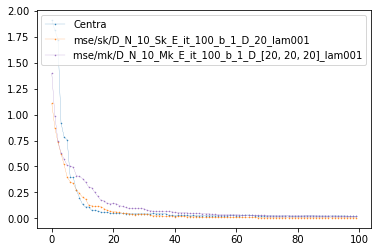

In [335]:
################ MSE plot ####################
import os
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
colors=list(mcolors.TABLEAU_COLORS.keys())
# print('mse:{}'.format(mse))
plt.figure(0)
de_path='./'
plt.plot(range(0,mse.shape[0]),mse,'.-',linewidth=0.2,markersize=1,color=mcolors.TABLEAU_COLORS[colors[0]])

sk_pt='mse/sk/D_N_10_Sk_E_it_100_b_1_D_20_lam001'
sk_path=de_path+sk_pt+'.pt'
sk_mse=torch.load(sk_path)
plt.plot(range(0,sk_mse.shape[0]),sk_mse,'.-',linewidth=0.2,markersize=1,color=mcolors.TABLEAU_COLORS[colors[1]])
mk_pt='mse/mk/D_N_10_Mk_E_it_100_b_1_D_[20, 20, 20]_lam001'
mk_path=de_path+mk_pt+'.pt'
mk_mse=torch.load(mk_path)
plt.plot(range(0,mk_mse.shape[0]),mk_mse,'.-',linewidth=0.2,markersize=1,color=mcolors.TABLEAU_COLORS[colors[4]])
# mk_pt='mse/mk/D_N_5_Mk_E_it_200_b_10_D_[10, 10, 10]_lam001'
# mk_path=de_path+mk_pt+'.pt'
# mk_mse=torch.load(mk_path)
# plt.plot(range(0,mk_mse.shape[0]),mk_mse,'.-',linewidth=0.2,markersize=1,color=mcolors.TABLEAU_COLORS[colors[2]])

# #########
# mk_pt1='mse/mk/D_N_5_Mk_E_it_200_b_10_D_[20, 20, 20]_lam001'
# mk_path=de_path+mk_pt1+'.pt'
# mk_mse=torch.load(mk_path)
# plt.plot(range(0,mk_mse.shape[0]),mk_mse,'.-',linewidth=0.2,markersize=1,color=mcolors.TABLEAU_COLORS[colors[3]])

# mk_pt2='mse/mk/D_N_5_Mk_E_it_200_b_10_D_[30, 30, 30]_lam001'
# mk_path=de_path+mk_pt2+'.pt'
# mk_mse=torch.load(mk_path)
# plt.plot(range(0,mk_mse.shape[0]),mk_mse,'.-',linewidth=0.2,markersize=1,color=mcolors.TABLEAU_COLORS[colors[4]])

# mk_pt3='mse/mk/N_5_lam_001'
# mk_path=de_path+mk_pt3+'.pt'
# mk_mse=torch.load(mk_path)
# plt.plot(range(0,mk_mse.shape[0]),mk_mse,'.-',linewidth=0.2,markersize=1,color=mcolors.TABLEAU_COLORS[colors[5]])


#########

plt.legend(['Centra','{}'.format(sk_pt),'{}'.format(mk_pt)])
plt.savefig('figs/CEN_MSE_it_{}_b_{}_D_{}.png'.format(int(T),batch,D),dpi=600)

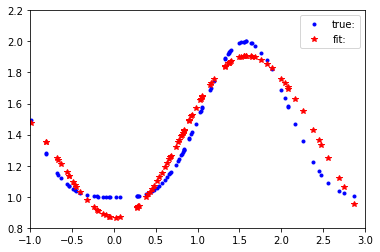

In [334]:

X=torch.randn(testN,dim)+1
yt=fun(X)
yhat=kernel.Fit(X)
from matplotlib import pyplot as plt
plt.plot(X[:,0],yt,'b.')
plt.plot(X[:,0],yhat,'r*')
[xmin,xmax,ymin,ymax]=[-1,3,0.8,2.2]
plt.axis([xmin,xmax,ymin,ymax])
plt.legend(['true:','fit:'])
plt.savefig('figs/cen/CEN_FIT_it_{}_b_{}_D_{}.png'.format(int(T),batch,D),dpi=600)